<a href="https://colab.research.google.com/github/dangtbthi/diffusion-mnist/blob/main/ddpmlike_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.nn.init as init
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt

from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

%pip install torchinfo -q
from torchinfo import summary

# Dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.90MB/s]


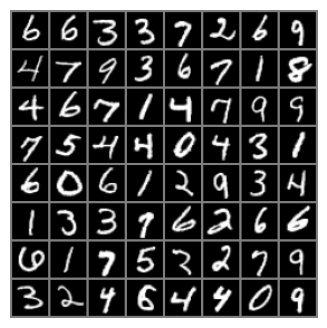

tensor([6, 6, 3, 3, 7, 2, 6, 9, 4, 7, 9, 3, 6, 7, 1, 8, 4, 6, 7, 1, 4, 7, 9, 9,
        7, 5, 4, 4, 0, 4, 3, 1, 6, 0, 6, 1, 2, 9, 3, 4, 1, 3, 3, 7, 6, 2, 6, 6,
        6, 1, 7, 5, 3, 2, 7, 9, 3, 2, 4, 6, 4, 4, 0, 9])


In [3]:
# Hiển thị ảnh
def imshow(img, title=None):
    img = img / 2 + 0.5  # Bỏ chuẩn hóa
    npimg = img.numpy()
    plt.figure(figsize=(12, 4))  # Kích thước ảnh
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # (C, H, W) → (H, W, C)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Lấy một batch từ dataloader
images, labels = next(iter(train_loader))

# Ghép ảnh thành lưới rồi hiển thị
imshow(torchvision.utils.make_grid(images))
print(labels)

# Diffusion Model

The idea of diffusion model is to systematically and slowly destroy structure a data distribution through an iterative foward diffusion process. We then a train a neural network to predict the noise that was added to the clean image x at timestamp t (in the foward process).

## Foward Process: Noise Scheduler

The forward process adds noise (a stochastic process described by a stochastic differential equation, SDE) to the data:
$$
q(x_t \mid x_{t-1}) = \mathcal{N}\Big(x_t;\sqrt{(1-β_t)}x_{t-1},\beta_tI\Big)
$$
where $\{ \beta_t \}_{t=1}^T$ is the noise schedule so that $q(x_T) \sim \mathcal{N}(0,I)$. This defines a Markov chain: each $x_t$ depends only on $x_{t-1}$. \
From $q(x_t \mid x_{t-1})$ we can obtain $q(x_t \mid x_0)$ with any $1 \le t \le T$ using the reparameterization trick:
$$
\begin{aligned}
x_t
&= \sqrt{1-\beta_t} \, x_{t-1} + \sqrt{\beta_t} \, \epsilon_t \\
&= \sqrt{1-\beta_t}\Big(\sqrt{1-\beta_{t-1}} \, x_{t-2} + \sqrt{\beta_{t-1}} \, \epsilon_{t-1}\Big) + \sqrt{\beta_t} \, \epsilon_t \\
&= \cdots \\
&= \Big(\prod_{s=1}^t \sqrt{1-\beta_s}\Big) x_0 + \sum_{s=1}^t \sqrt{\beta_s} \Big(\prod_{u=s+1}^t \sqrt{1-\beta_u}\Big) \epsilon_s
\end{aligned}
$$
We have $\alpha_t = 1-\beta_t$ và $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$
$$
x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1-\bar{\alpha}_t} \, \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$
Therefore:
$$
q(x_t \mid x_0) = \mathcal{N}\Big(x_t;\sqrt{\bar{\alpha}_t} \, x_0, \, (1-\bar{\alpha}_t) I \Big)
$$

In [4]:
class NoiseScheduler():
    def __init__(self, num_timesteps, beta_start=0.0001, beta_end=0.02, device = "cpu"):
        super().__init__()
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.num_timesteps = num_timesteps

        self.betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        self.sqrt_alpha_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        # Additional terms for the reverse process
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod.roll(1).clamp(min=1e-20)) / (1. - self.alphas_cumprod)

    def get_index_from_list(self, vals, t, x_shape):
        """
        Returns a specific index t of a passed list of values vals
        while considering the batch dimension.
        """
        batch_size = t.shape[0]
        out = vals.gather(0, t.to(vals.device))
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

    def forward(self, x_0, t):
        """
        Takes an image and a timestep as input and
        returns the noisy version of it
        """
        noise = torch.randn_like(x_0).to(self.betas.device)
        mean = self.get_index_from_list(self.sqrt_alpha_cumprod, t, x_0.shape) * x_0
        std = self.get_index_from_list(self.sqrt_one_minus_alpha_cumprod, t, x_0.shape)
        return mean + std * noise, noise

In [5]:
T = 300
device = "cuda" if torch.cuda.is_available() else "cpu"
noise_scheduler = NoiseScheduler(T, device = device)

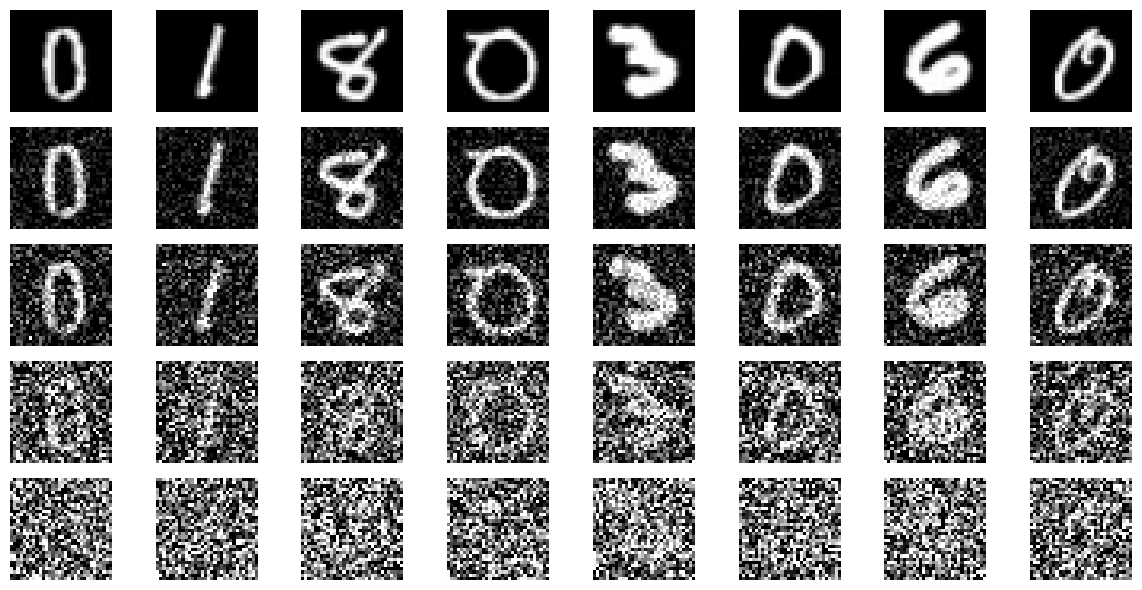

In [6]:
# Simulate forward diffusion
images, _ = next(iter(train_loader))
x0 = images[:8].to(device) # Move x0 to the specified device
timesteps = torch.tensor([0, 50, 100, 200, 299])

fig, axes = plt.subplots(len(timesteps), x0.shape[0], figsize=(12, 6))

for row, t in enumerate(timesteps):
    t_batch = torch.tensor([t] * x0.shape[0]).to(device) # Move t_batch to the specified device
    noisy_imgs, _ = noise_scheduler.forward(x0, t_batch)
    for col in range(x0.shape[0]):
        img = noisy_imgs[col].detach().cpu()
        img = img / 2 + 0.5  # de-normalize về [0,1]
        img = img.permute(1, 2, 0).numpy().clip(0, 1)

        axes[row, col].imshow(img.squeeze(), cmap="gray")
        axes[row, col].axis("off")

        '''
def imshow(img, title=None):
    img = img / 2 + 0.5  # Bỏ chuẩn hóa
    npimg = img.numpy()
    plt.figure(figsize=(12, 4))  # Kích thước ảnh
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # (C, H, W) → (H, W, C)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()
        '''

plt.tight_layout()
plt.show()

## Reverse Process: U-Net

Diffusion model is one of score-based generative models, and the reverse process is a score model. Our goal is to find $p_θ(x_t \mid x_0)$ so we can start from pure noise $x_T \sim \mathcal{N}(0, I)$ and gradually denoise it step-by-step to generate a clean image $x_0$.

The problem is that the true reverse distribution $q(x_{t-1} \mid x_t)$ is intractable. Score function can solve this challenge.

The score function of a probability density $p(x)$ is defined as its gradient with respect to the data x:
$$
\nabla_x \log p(x)
$$
The score function acts as a vector field that points in the direction of the highest increase in data density. By learning this field, a model can start with a random noise sample and iteratively "climb" the probability landscape by taking small steps in the direction indicated by the score. This process effectively guides the random sample towards a high-density region, transforming it into a realistic new data point that looks like it was drawn from the original dataset.

**Score Function**



In [7]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        # time: (B,) or (B,1) integer/float
        if time.dim() == 2 and time.shape[1] == 1:
            time = time[:, 0]
        device = time.device
        time = time.float()
        half_dim = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(half_dim, device=device).float() / (half_dim - 1))
        args = time[:, None] * freqs[None, :]  # (B, half_dim)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            emb = torch.cat([emb, torch.zeros(time.shape[0], 1, device=device)], dim=-1)
        return emb

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim: int = None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        if time_emb_dim is not None:
            self.time_mlp = nn.Sequential(
                nn.Linear(time_emb_dim, out_channels),
                nn.ReLU()
            )
        else:
            self.time_mlp = None

    def forward(self, x, t=None):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.relu1(h)

        if (t is not None) and (self.time_mlp is not None):
            te = self.time_mlp(t.float())  # (B, out_channels)
            te = te[:, :, None, None]      # (B, out_channels, 1, 1)
            h = h + te

        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu2(h)
        return h

In [9]:
class UNetDenoiser(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=(64, 128, 256, 512), time_emb_dim=128):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.features = features
        self.time_emb_dim = time_emb_dim

        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        self.downs = nn.ModuleList()
        prev_ch = in_channels
        for feat in features:
            self.downs.append(DoubleConv(prev_ch, feat, time_emb_dim=time_emb_dim))
            prev_ch = feat
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2, time_emb_dim=time_emb_dim)

        self.ups = nn.ModuleList()
        rev_features = list(reversed(features))
        for feat in rev_features:
            self.ups.append(nn.ConvTranspose2d(feat * 2, feat, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feat * 2, feat, time_emb_dim=time_emb_dim))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x, timestep):
        # ensure timestep on same device
        timestep = timestep.to(x.device)
        t = self.time_embedding(timestep)  # (B, time_emb_dim)

        skip_connections = []
        out = x
        for down in self.downs:
            out = down(out, t)
            skip_connections.append(out)
            out = self.pool(out)

        out = self.bottleneck(out, t)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            upconv = self.ups[idx]
            doubleconv = self.ups[idx + 1]

            out = upconv(out)
            skip = skip_connections[idx // 2]
            if out.shape[2:] != skip.shape[2:]:
                out = TF.resize(out, size=skip.shape[2:])

            out = torch.cat((skip, out), dim=1)
            out = doubleconv(out, t)

        return self.final_conv(out)

In [10]:
def get_loss(model, x_0, t, scheduler: NoiseScheduler, loss_type: str = "l1"):
    device = x_0.device
    t = t.to(device)
    x_noisy, noise = scheduler.forward(x_0, t)
    noise_pred = model(x_noisy, t)  # model expects timestep on same device
    if loss_type.lower() in ("l1", "mae"):
        return F.l1_loss(noise_pred, noise)
    else:
        return F.mse_loss(noise_pred, noise)

# Sample

In [11]:
@torch.no_grad()
def sample_timestep(x, t, model, scheduler: NoiseScheduler):
    """
    x: (B, C, H, W)
    t: (B,) long
    returns next x_{t-1}
    """
    device = x.device

    betas_t = scheduler.get_index_from_list(scheduler.betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = scheduler.get_index_from_list(
        scheduler.sqrt_one_minus_alpha_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = scheduler.get_index_from_list(scheduler.sqrt_recip_alphas, t, x.shape)

    # model predicts noise
    noise_pred = model(x, t)  # model handles casting inside

    model_mean = sqrt_recip_alphas_t * (x - betas_t * noise_pred / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = scheduler.get_index_from_list(scheduler.posterior_variance, t, x.shape)

    # batch-aware: if some entries t==0, don't add noise to those entries
    if x.shape[0] == 1:
        # single example in batch
        if int(t.item()) == 0:
            return model_mean
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise
    else:
        noise = torch.randn_like(x)
        mask = (t != 0).float().reshape(x.shape[0], *([1] * (x.ndim - 1))).to(device)
        return model_mean + torch.sqrt(posterior_variance_t) * noise * mask

@torch.no_grad()
def sample_plot_image(model, scheduler, T, img_size, device, show_tensor_image, num_images=8):
    img = torch.randn((1, 1, img_size, img_size), device=device)
    plt.figure(figsize=(num_images * 2, 2))
    plt.axis('off')

    stepsize = max(1, T // num_images)
    plot_idx = 0

    for i in range(T - 1, -1, -1):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, model, scheduler)
        img = torch.clamp(img, -1.0, 1.0)
        if (i % stepsize == 0 or i == 0) and plot_idx < num_images:
            plt.subplot(1, num_images, plot_idx + 1)
            plt.axis('off')
            show_tensor_image(img.detach().cpu())
            plot_idx += 1
    plt.show()

In [12]:
def show_tensor_image(tensor_image):
    """
    tensor_image: torch.Tensor, shape (1, C, H, W) or (C, H, W)
    expects values in [-1, 1] (clamped above)
    """
    if tensor_image.dim() == 4:
        img = tensor_image[0]
    else:
        img = tensor_image
    # img shape: (C, H, W)
    if img.shape[0] == 1:
        plt.imshow(img[0], cmap="gray", vmin=-1.0, vmax=1.0)
    else:
        plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')

Using device: cuda
Start Training...


Epoch 20/20: 100%|██████████| 938/938 [00:46<00:00, 20.18it/s, loss=0.0716]


Start Sampling...


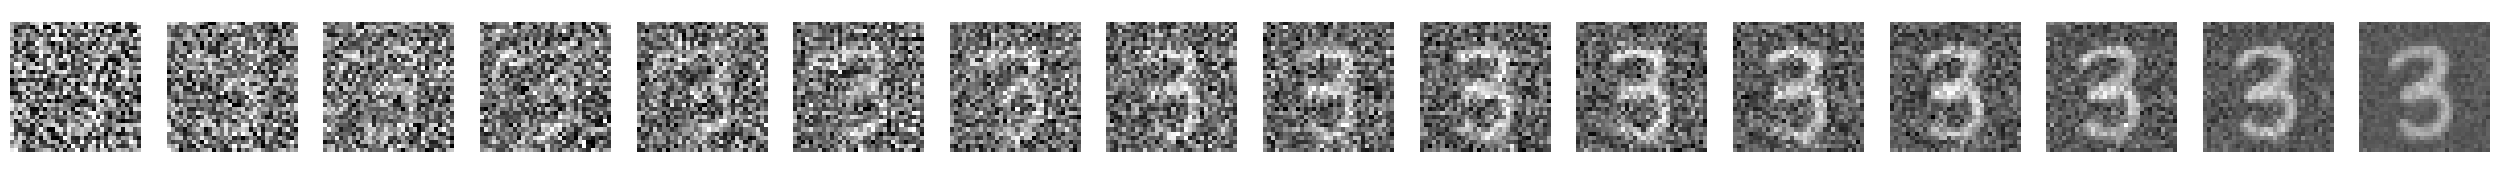

In [13]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    T = 300
    IMG_SIZE = 32
    EPOCHS = 20
    LEARNING_RATE = 1e-3

    scheduler = NoiseScheduler(num_timesteps=T, device=device)
    model = UNetDenoiser(in_channels=1, out_channels=1, features=(32, 64, 128, 256), time_emb_dim=256).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("Start Training...")
    losses = []
    for epoch in range(EPOCHS):
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for step, (images, _) in enumerate(progress_bar):
            optimizer.zero_grad()

            x0 = images.to(device)

            t = torch.randint(0, T, (x0.shape[0],), device=device).long()

            loss = get_loss(model, x0, t, scheduler, loss_type="l1")

            loss.backward()
            optimizer.step()

            progress_bar.set_postfix(loss=loss.item())
            losses.append(loss.item())

    print("Start Sampling...")
    sample_plot_image(model, scheduler, T, IMG_SIZE, device, show_tensor_image=show_tensor_image, num_images=16)